<h1><center><font size="25">Skforecast: time series forecasting with Python and Scikit-learn</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>February, 2021 (last update September 2022)</i></center>

+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Bitcoin price prediction with Python, when the past does not repeat itself](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)

## Introduction
<br>

A time series is a succession of chronologically ordered data spaced at equal or unequal intervals. The forecasting process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

<div>
<img src='./images/forecasting_multi-step_en.gif' width="600"/>
</div>

This document describes how to use [**Scikit-learn**](https://scikit-learn.org/stable/) regression models to perform forecasting on time series. Specifically, it introduces [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/), a simple library that contains the classes and functions necessary to adapt any **Scikit-learn** regression model to forecasting problems.

More examples in [skforecast-examples](https://joaquinamatrodrigo.github.io/skforecast/latest/examples/examples.html).
<br><br>

## Machine learning for forecasting
<br>

In order to apply machine learning models to forecasting problems, the time series has to be transformed into a matrix in which each value is related to the time window (lags) that precedes it.

In a time series context, a lag with respect to a time step $t$ is defined as the values of the series at previous time steps. For example, lag 1 is the value at time step $t − 1$ and lag $m$ is the value at time step $t − m$.

<img src="./images/transform_timeseries.gif" style="width: 550px;">
<br>

<center><font size='2.5'> <i>Time series transformation into a matrix of 5 lags and a vector with the value of the series that follows each row of the matrix.</i></font></center>

This type of transformation also allows to include additional variables.

<img src="./images/matrix_transformation_with_exog_variable.png" style="width: 550px;">

<center><font size='2.5'> <i>Time series transformation including an exogenous variable.</i></font></center>

Once data have been rearranged into the new shape, any regression model can be trained to predict the next value (step) of the series. During model training, every row is considered a separate data instance, where values at lags 1, 2, ... $p$ are considered predictors for the target quantity of the time series at time step $p + 1$. 

## Multi-Step Time Series Forecasting
<br>

When working with time series, it is seldom needed to predict only the next element in the series ($t_{+1}$). Instead, the most common goal is to predict a whole future interval (($t_{+1}$), ..., ($t_{+n}$)) or a far point in time ($t_{+n}$). Several strategies allow generating this type of prediction.
<br><br>

### Recursive multi-step forecasting
<br>

Since the value $t_{n-1}$ is required to predict $t_{n}$, and $t_{n-1}$ is unknown, a recursive process is applied in which, each new prediction, is based on the previous one. This process is known as recursive forecasting or recursive multi-step forecasting and can be easily generated with the `ForecasterAutoreg` and `ForecasterAutoregCustom` classes.

<div>
<img src='./images/diagram-recursive-mutistep-forecasting.png' width="650"/>
</div>

<center><font size='2.5'> <i>Recursive multi-step prediction process diagram to predict 3 steps into the future using the last 4 lags of the series as predictors.</i></font></center>

### Direct multi-step forecasting

Direct multi-step forecasting consists of training a different model for each step of the forecast horizon. For example, to predict the next 5 values of a time series, 5 different models are trained, one for each step. As a result, the predictions are independent of each other.

<p align="center"><img src="./images/diagram-direct-multi-step-forecasting.png" style="width: 700px"></p>

<center><font size='2.5'> <i>Direct multi-step prediction process diagram to predict 3 steps into the future using the last 4 lags of the series as predictors.</i></font></center>

<br><br>

The main complexity of this approach is to generate the correct training matrices for each model. The `ForecasterAutoregDirect` class of the **skforecast** library automates this process. It is also important to bear in mind that this strategy has a higher computational cost since it requires the train of multiple models. The following diagram shows the process for a case in which the response variable and two exogenous variables are available.

<img src="./images/diagram_skforecast_multioutput.png" style="width: 900px;">

<center><font size='2.5'> <i>Transformation of a time series into matrices to train a direct multi-step forecasting model</i></font></center>

<br><br>

### Multiple output forecasting
<br>

Some machine learning models, such as long short-term memory (LSTM) neural network, can predict simultaneously several values of a sequence (one-shot). This strategy is not currently implemented in **skforecast** library.
<br><br>

## Recursive autoregressive forecasting
<br>

A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. It is intended to create an autoregressive model capable of predicting future monthly expenditures.
<br>

### Libraries
<br>

The libraries used in this document are:

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

### Data
<br>

The data used in the examples of this document have been obtained from the magnificent book [Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [2]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

The column `date` has been stored as a `string`. To convert it to `datetime` the `pd.to_datetime()` function can be use. Once in `datetime` format, and to make use of **Pandas** functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [3]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


When setting a frequency with the `asfreq()` method, **Pandas** fills the gaps that may exist in the time series with the value of `Null` to ensure the indicated frequency. Therefore, it should be checked if missing values have appeared after this transformation.

In [4]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


Although it is unnecessary, since a frequency has been established, it is possible to verify that the time series is complete.

In [5]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [6]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

The last 36 months are used as the test set to evaluate the predictive capacity of the model.

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


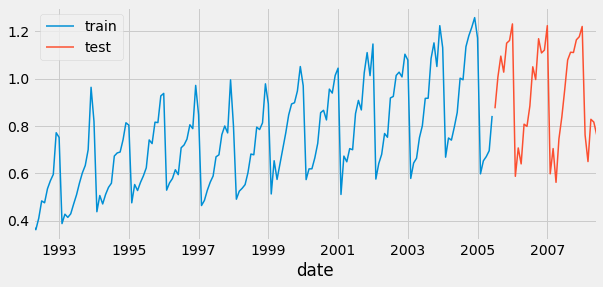

In [7]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg
<br>

With the `ForecasterAutoreg` class, a model is created and trained from a `RandomForestRegressor` regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [8]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-29 11:25:35 
Last fit date: 2022-09-29 11:25:35 
Skforecast version: 0.5.0 
Python version: 3.9.13 

### Predictions
<br>

Once the model is trained, the test data is predicted (36 months into the future).

In [9]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

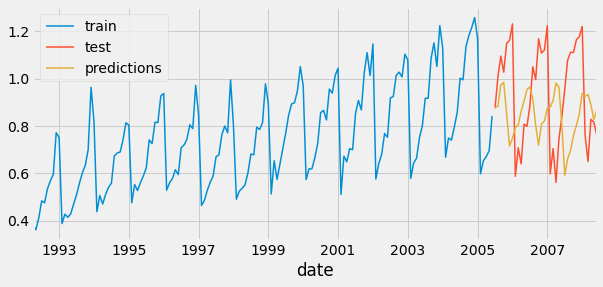

In [10]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set
<br>

The error that the model makes in its predictions is quantified. In this case, the metric used is the mean squared error (mse).

In [11]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.07326833976120374


### Hyperparameter tuning
<br>

The trained `ForecasterAutoreg` uses a 6 lag time window and a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model with the default hyperparameters. However, there is no reason why these values are the most suitable. In order to identify the best combination of lags and hyperparameters, the **Skforecast** library provides the `grid_search_forecaster` function. It compares the results obtained with each model configuration.

For more detailed documentation, visit: [skforecast grid search forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html).

In [12]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:21<00:00, 10.91s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.012836389345193383



In [13]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.012836,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.012858,3,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.013248,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.013364,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.013435,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.014028,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.036982,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.037345,3,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.037574,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.040542,10,500


The best results are obtained using a time window of 20 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 500}.

### Final model
<br> 

Finally, a `ForecasterAutoreg` is trained with the optimal configuration found by validation. This step is not necessary if `return_best = True` is specified in the `grid_search_forecaster` function.

In [14]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [15]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

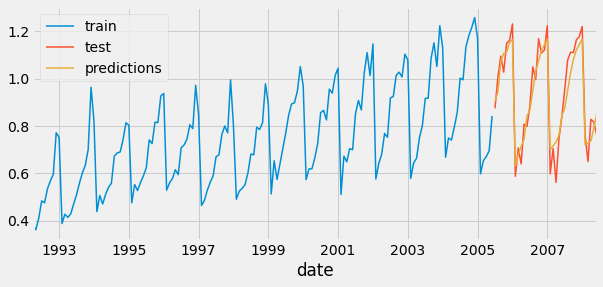

In [16]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [17]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.004392699665157793


The optimal combination of hyperparameters significantly reduces test error.
<br><br>

### Backtesting

Backtesting is a term used in modeling to refer to testing a predictive model on historical data. Backtesting involves moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it is a special type of cross-validation applied to previous period(s).

**Backtesting with refit and increasing training size (fixed origin)**

The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

<img src="./images/diagram-backtesting-refit.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and retraining at each iteration.</i></font></center>

**Backtesting with refit and fixed training size (rolling origin)**

A technique similar to the previous one but, in this case, the forecast origin rolls forward, therefore, the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.

<img src="./images/diagram-backtesting-refit-fixed-train-size.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and a training set of constant size.</i></font></center>

**Backtesting without refit**

After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is trained only once. However, the model does not incorporate the latest data available, so it may lose predictive capacity over time.

<img src="./images/diagram-backtesting-no-refit.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and no retraining at each iteration.</i></font></center>
<br>

The **skforecast** library has the mentioned [backtesting strategies](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html#backtesting) implemented. Regardless of which one is used, it is important not to include test data in the search process to avoid overfitting problems.

For this example, a **backtesting with refit** strategy is followed. Internally, the process that the function applies is:

+ In the first iteration, the model is trained with the observations selected for the initial training (in this case, 87). Then, the next 36 observations are used to validate the predictions of this first model.

+ In the second iteration, the model is retrained by adding, to the initial training set, the previous 36 validation observations (87 + 36). In the same way, the next 36 observations are established as the new validation set.

+ This process is repeated until all available observations are used. Following this strategy, the training set increases in each iteration with as many observations as steps are being predicted.

In [18]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)

Backtest error: 0.010578977232387663


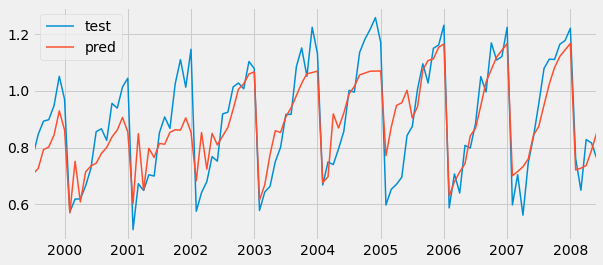

In [19]:
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

### Predictors importance
<br>

Since the `ForecasterAutoreg` object uses **Scikit-learn** models, the importance of predictors can be accessed once trained. When the regressor used is a `LinearRegression()`, `Lasso()` or `Ridge()`, the coefficients of the model reflect their importance. In `GradientBoostingRegressor()` or `RandomForestRegressor()` regressors, the importance of predictors is based on impurity.

*Note: the `get_feature_importance()` method only returns values if the regressor used within the forecaster has the attribute `coef_` or `feature_importances_`.*

In [20]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.009412
1,lag_2,0.087268
2,lag_3,0.012754
3,lag_4,0.001446
4,lag_5,0.000401
5,lag_6,0.001386
6,lag_7,0.001273
7,lag_8,0.006926
8,lag_9,0.005839
9,lag_10,0.013076


## Recursive autoregressive forecasting with exogenous variables
<br>

In the previous example, only lags of the predicted variable itself have been used as predictors. In certain scenarios,  it is possible to have information about other variables, **whose future value is known**, so could serve as additional predictors in the model.

Continuing with the previous example, a new variable whose behavior is correlated with the modeled time series and it is wanted to incorporate as a predictor is simulated. The same applies to multiple exogenous variables.
<br><br>

### Data

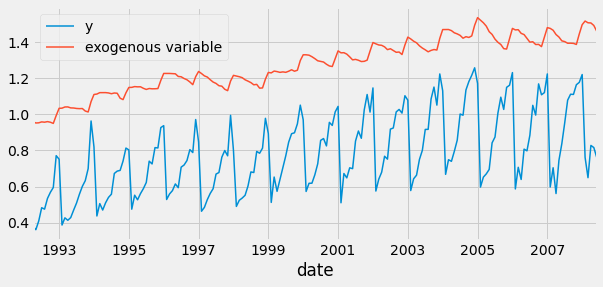

In [21]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(9, 4))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend();

In [22]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


### ForecasterAutoreg

In [23]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-29 11:26:04 
Last fit date: 2022-09-29 11:26:04 
Skforecast version: 0.5.0 
Python version: 3.9.13 

### Predictions
<br>

If the `ForecasterAutoreg` is trained with an exogenous variable, the value of this variable must be passed to `predict()`. It is only applicable to scenarios in which future information on the exogenous variable is available.

In [24]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

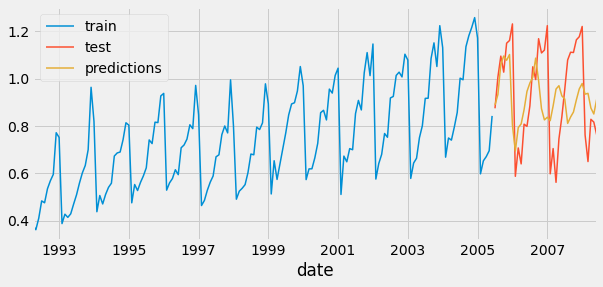

In [25]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

In [26]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.03989087922533575


### Hyperparameter tuning

In [27]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    exog        = data_train['exog_1'],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 27.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:34<00:00, 11.66s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.007172428407773492



In [28]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",0.007172,10,50
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",0.007176,10,100
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 500}",0.007535,10,500
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 500}",0.007960,5,500
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",0.008168,5,100


The best results are obtained using a time window of 12 lags and a Random Forest set up of {'max_depth': 10, 'n_estimators': 50}.

### Final model
<br>

Setting `return_best = True` in `grid_search_forecaster`, after the search, the `ForecasterAutoreg` object has been modified and trained with the best configuration found.

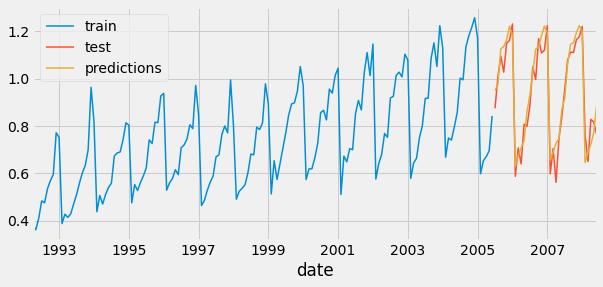

In [29]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [30]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.0044949967759907675


## Recursive autoregressive forecasting with custom predictors
<br>

In addition to the lags, it may be interesting to incorporate other characteristics of the time series in some scenarios. For example, the moving average of the last *n* values could be used to capture the series's trend.

The `ForecasterAutoregCustom` class behaves very similar to the `ForecasterAutoreg` class seen in the previous sections, but with the difference that it is the user who defines the function used to create the predictors.

The first example of the document about predicting the last 36 months of the time series is repeated. In this case, the predictors are the first 10 lags and the values' moving average of the lasts 20 months.
<br><br>

### Data

In [31]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


### ForecasterAutoregCustom
<br>

A `ForecasterAutoregCustom` is created and trained from a `RandomForestRegressor` regressor. The `create_predictor()` function,  which calculates the first 10 lags and the moving average of the last 20 values, is used to create the predictors.

In [32]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

When creating the forecaster, the `window_size` argument must be equal to or greater than the window used by the function that creates the predictors. This value, in this case, is 20.

In [33]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Window size: 20 
Transformer for y: None 
Transformer for exog: None 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-29 11:26:40 
Last fit date: 2022-09-29 11:26:40 
Skforecast version: 0.5.0 
Python version: 3.9.13 

It is possible to access the custom function used to create the predictors.

In [34]:
print(forecaster.source_code_create_predictors)

def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors



Using the method `create_train_X_y`, is it posible to acces the matrices that are created internally in the training process.

In [35]:
X, y = forecaster.create_train_X_y(y=data_train['y'])
X.head(4)

,custom_predictor_0,custom_predictor_1,custom_predictor_2,custom_predictor_3,custom_predictor_4,custom_predictor_5,custom_predictor_6,custom_predictor_7,custom_predictor_8,custom_predictor_9,custom_predictor_10
date,,,,,,,,,,,
1993-12-01,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.387554,0.523089
1994-01-01,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.552253
1994-02-01,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.575129
1994-03-01,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.576486


In [36]:
y.head(4)

date
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
Freq: MS, Name: y, dtype: float64

### Predictions

In [37]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)

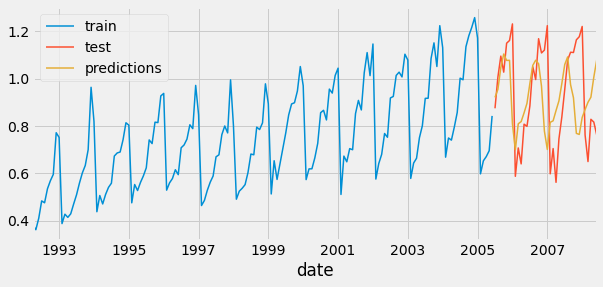

In [38]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

In [39]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.046232546768232


### Hyperparameter tuning
<br>

When using the `grid_search_forecaster` function with a `ForecasterAutoregCustom`, the` lags_grid` argument is not specified.

In [40]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    param_grid  = param_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 6.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:10<00:00, 10.61s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.03431493238511672



In [41]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",0.034315,5,500
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.035424,5,100
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.035572,10,100
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",0.035790,3,500
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",0.035878,3,100
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",0.036010,10,500


### Final model

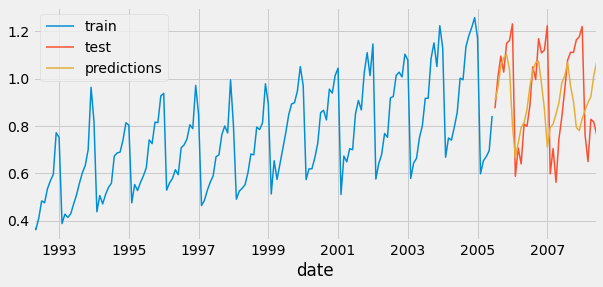

In [42]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [43]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.04194326997422299


## Direct multi-step forecasting
<br>

The `ForecasterAutoreg` and `ForecasterAutoregCustom` models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results. These kinds of models can be obtained with the `ForecasterAutoregDirect` class and can include one or multiple exogenous variables.
<br><br>

### ForecasterAutoregDirect
<br>

Unlike when using `ForecasterAutoreg` or `ForecasterAutoregCustom`, the number of steps to be predicted must be indicated in the `ForecasterAutoregDirect` type models. This means that the number of predictions obtained when executing the `predict()` method is always the same. It is not possible to predict steps beyond the value defined at their creation.

For this example, a linear model with `Lasso` penalty is used as a regressor. These models require the predictors to be standardized, so it is combined with a `StandardScaler`.

For more detailed documentation how to use transformers and pipelines, visit: [skforecast with scikit-learn and transformers pipelines](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/sklearn-transformers-and-pipeline.html).

In [44]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8
             )

forecaster

ForecasterAutoregDirect 
Regressor: Lasso(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 8 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': 123, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
Creation date: 2022-09-29 11:26:52 
Last fit date: None 
Skforecast version: 0.5.0 
Python version: 3.9.13 

In [45]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # This value will be replaced in the grid search
             )

# To access parameters of a scikitlearn pipeline the pattern:
# <name of the step>__<name of the parameter>.
param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = True,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
                )

Number of models compared: 30.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.021544346900318846}
  Backtesting metric: 0.013096775271454832



In [46]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,alpha
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.021544346900318846},0.013097,0.021544
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.021544346900318846},0.013681,0.021544
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0016681005372000592},0.014560,0.001668
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0001291549665014884},0.014647,0.000129
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 1e-05},0.014649,0.000010


The best results are obtained using a time window of 12 lags and a Lasso setting {'alpha': 0.021544}.

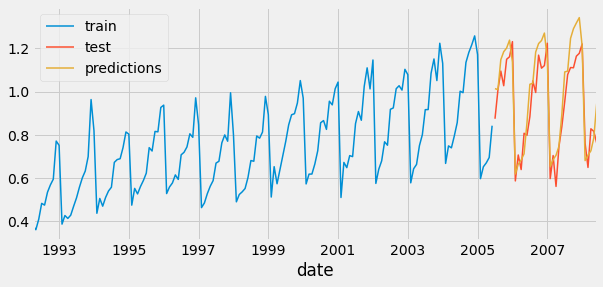

In [47]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [48]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.0107771561305922


## Prediction intervals
<br>

A prediction interval defines the interval within which the true value of $y$ is expected to be found with a given probability.

Rob J Hyndman and George Athanasopoulos, list in their book *Forecasting: Principles and Practice* [multiple ways to estimate prediction intervals](https://otexts.com/fpp3/prediction-intervals.html), most of which require that the residuals (errors) of the model are distributed in a normal way. When this property cannot be assumed, bootstrapping can be resorted to, which only assumes that the residuals are uncorrelated. This is the method used in the **Skforecast** library for the `ForecasterAutoreg` and `ForecasterAutoregCustom` type models. For example, the prediction interval (1, 99) can be expected to contain the true prediction value with 98% probability.

<div>
<img src='./images/bootstrapped-prediction-interval.gif'/>
</div>

<center><font size='2.5'> <i>Diagram of how to create prediction intervals using bootstrapping.</i></font></center>

<br><br>

In [49]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data_raw = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data_raw.copy()
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [50]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=data_train['y'])

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
              )

predictions.head(5)

,pred,lower_bound,upper_bound
2005-07-01,0.962317,0.836348,1.072365
2005-08-01,0.976595,0.786105,1.093848
2005-09-01,1.140783,0.976097,1.262243
2005-10-01,1.179538,1.009499,1.306744
2005-11-01,1.221138,1.059447,1.348892


Test error (mse): 0.010536580526702767


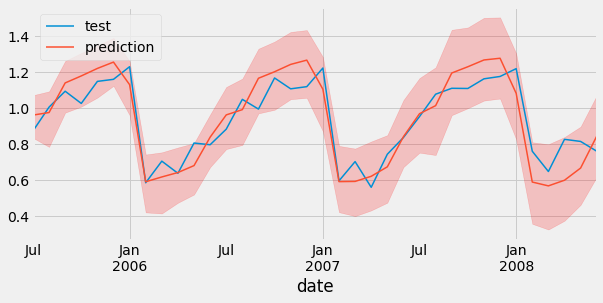

In [51]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions.iloc[:, 0]
            )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_test['y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)

Test error (mse): 0.010536580526702767


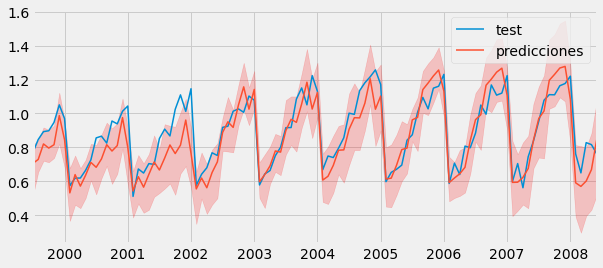

In [52]:
# Backtest with prediction intervals
# ==============================================================================
n_backtesting = 36*3 # The last 9 years are separated for backtesting
steps = 36
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 15
             )

metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            initial_train_size = len(data) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                      )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions.index, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [53]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                     (data.loc[predictions.index, 'y'] >= predictions['lower_bound']) & \
                     (data.loc[predictions.index, 'y'] <= predictions['upper_bound']),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 84.26 %


## Custom metric
<br>

In the backtesting (`backtesting_forecaster`) and hyperparameter optimization (`grid_search_forecaster`) processes, besides the frequently used metrics: mean_squared_error, mean_absolute_error, and mean_absolute_percentage_error, it is possible to use any custom function as long as:

+ It includes the arguments:

    + `y_true`: true values of the series.

    + `y_pred`: predicted values.

+ It returns a numeric value (`float` or `int`).

+ The metric is reduced as the model improves. Only applies in the `grid_search_forecaster` function if `return_best=True` (train the forecaster with the best model).

It allows evaluating the predictive capability of the model in a wide range of scenarios, for example:

+ Consider only certain months, days, hours...

+ Consider only dates that are holidays.

+ Consider only the last step of the predicted horizon.

The following example shows how to forecast a 12-month horizon but considering only the last 3 months of each year to calculate the interest metric.

In [54]:
# Custom metric 
# ==============================================================================
from sklearn.metrics import mean_absolute_error

def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

In [55]:
# Backtesting 
# ==============================================================================
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for backtesting

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = custom_metric,
                                    verbose            = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)

Backtest error: 0.12033751744029438


## Save and load models
<br>

Skforecast models can be stored and loaded from disck using pickle or joblib library. To simply the process, two functions are available: `save_forecaster` and `load_forecaster`,  simple example is shown below. For more detailed documentation, visit: [skforecast save and load forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/save-load-forecaster.html).

In [56]:
# Create forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=data['y'])
forecaster.predict(steps=3)

2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

In [57]:
# Save model
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)

In [58]:
# Load model
forecaster_loaded = load_forecaster('forecaster.py')

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-29 11:26:59 
Last fit date: 2022-09-29 11:26:59 
Skforecast version: 0.5.0 
Python version: 3.9.13 



In [59]:
# Predict
forecaster_loaded.predict(steps=3)

2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

## Use forecaster in production
<br>

In projects related to forecasting, it is common to generate a model after the experimentation and development phase. For this model to have a positive impact on the business, it must be able to be put into production and generate forecasts from time to time with which to decide. This need has widely guided the development of the **Skforecast** library.

Suppose predictions have to be generated on a weekly basis, for example, every Monday. By default, when using the `predict` method on a trained forecaster object, predictions start right after the last training observation. Therefore, the model could be retrained weekly, just before the first prediction is needed, and call its `predict` method.

This strategy, although simple, may not be possible to use for several reasons:

+ Model training is very expensive and cannot be run as often.

+ The history with which the model was trained is no longer available.

+ The prediction frequency is so high that there is no time to train the model between predictions.

In these scenarios, the model must be able to predict at any time, even if it has not been recently trained.

Every model generated using **Skforecast** has the `last_window` argument in its `predict` method. Using this argument, it is possible to provide only the past values needs to create the autoregressive predictors (lags) and thus, generate the predictions without the need to retrain the model.

For more detailed documentation, visit: [skforecast forecaster in production](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/forecaster-in-production.html).

In [60]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=data_train['y'])

Since the model uses the last 6 lags as predictors, `last_window` must contain at least the 6 values previous to the moment where the prediction starts.

In [61]:
last_window = data_test['y'][-6:]
forecaster.predict(last_window=last_window, steps=4)

2008-07-01    0.757750
2008-08-01    0.836313
2008-09-01    0.877668
2008-10-01    0.911734
Freq: MS, Name: pred, dtype: float64

If the forecaster uses exogenous variables, besides `last_window`, the argument `exog` must contain the future values of the exogenous variables.

## Session information

In [62]:
import session_info
session_info.show(html=False)

-----
ipykernel           5.5.6
matplotlib          3.5.0
numpy               1.23.0
pandas              1.4.0
session_info        1.0.0
skforecast          0.5.0
sklearn             1.1.0
-----
IPython             8.5.0
jupyter_client      7.3.5
jupyter_core        4.11.1
notebook            6.4.12
-----
Python 3.9.13 (main, Aug 25 2022, 23:26:10) [GCC 11.2.0]
Linux-5.15.0-48-generic-x86_64-with-glibc2.31
-----
Session information updated at 2022-09-29 11:27


## Bibliography
<br>

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [Book](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [Book](https://openforecast.org/adam/)

Python Data Science Handbook by Jake VanderPlas [Book](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83)

Python for Finance: Mastering Data-Driven Finance [Book](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

**How to cite this document?**

<p style="text-align:left"><font size="3" color="#555">
Skforecast: time series forecasting with Python and Scikit-learn by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py27-forecasting-series-temporales-python-scikitlearn.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.